# Forecasting with LightGBM
- Distributed hyperparameter training
- Tracking metrics with MLflow
- Iterative Multi-step Forecasting (for now)  

In [25]:
import mlflow
import pandas as pd
# import optuna
import pickle
from pathlib import Path
import lightgbm as lgbm
# import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit 
# from skopt import BayesSearchCV
import numpy as np
import time

# Multiple outputs per notebook cell
%config InteractiveShell.ast_node_interactivity = 'all'

# random_state for different processes
RANDOM_STATE = 221

In [49]:
def num_rows_horizon(df, timeframe='7day'):
    ''' 
    Input: Dataframe, Timeframe (in to_timedelta format)
    Output: Outputs number of rows in dataframe to reach timeframe
    '''
    return len(df.loc[df['day'] > (df['day'].max() - pd.to_timedelta('7day'))])

def country_train_test(df, drop_index=True):
    ''' 
    Input: Dataframe from features prep
    Output: Data prepared for hyperparameter search
    '''
    X_train = (df.loc[df['country'] == 'BE'] # adjust this
                .drop(columns=['load_actual', 'country', 'day']) 
                .dropna() # remove NAs from creating lagged variables
                )
    if drop_index:
        X_train = X_train.reset_index(drop=True)
     

    y = (df.loc[df.country == 'BE']
        .reset_index(drop=True)[['load_actual']])
    
    return X_train, y


### Load Data
- Creating train/test and validation sets, then ensure windows are correct

In [26]:
cd = Path.cwd()
data_dir = str(cd.parents[1])
upsampled = data_dir + '/datasets/country_energy/load_wthr_downsample.pickle'
downsampled = data_dir + '/datasets/country_energy/load_wthr_upsample.pickle'

# Xu - upsampled
with open(upsampled, 'rb') as f:
    Xu = pickle.load(f)

# Xd - downsampled
with open(downsampled, 'rb') as f:
    Xd = pickle.load(f)

# Create test/train and validation set. Ensure dates are correct
final_test_u = Xu.loc[Xu['day'] > (Xu['day'].max() - pd.to_timedelta('8day'))] # 8 days is selected because last day 2019-4-30 has 0 hours
Xu = Xu.loc[Xu['day'] < (Xu['day'].max() - pd.to_timedelta('7day'))]
print(f'Ensure validation set is last 7 days; min date: {final_test_u.index.min()}, max date: {final_test_u.index.max()}')
print(f'Ensure train/test set excludes last 7 days; min date: {Xu.index.min()}, max date: {Xu.index.max()}')

final_test_d = Xd.loc[Xd['day'] > (Xd['day'].max() - pd.to_timedelta('8day'))]
Xd = Xd.loc[Xd['day'] < (Xd['day'].max() - pd.to_timedelta('7day'))]
print(f'Ensure validation set is last 7 days; min date: {final_test_d.index.min()}, max date: {final_test_d.index.max()}')
print(f'Ensure train/test set excludes last 7 days; min date: {Xd.index.min()}, max date: {Xd.index.max()}')

Ensure validation set is last 7 days; min date: 2019-04-23 00:00:00+00:00, max date: 2019-04-30 00:00:00+00:00
Ensure train/test set excludes last 7 days; min date: 2015-01-15 00:00:00+00:00, max date: 2019-04-22 23:45:00+00:00
Ensure validation set is last 7 days; min date: 2019-04-23 00:00:00+00:00, max date: 2019-04-30 00:00:00+00:00
Ensure train/test set excludes last 7 days; min date: 2015-01-15 00:00:00+00:00, max date: 2019-04-22 23:00:00+00:00


Prepare Data for Model Training

Objective Function (LightGBM) -- consider adding timing param within mlflow (assuming mlflow doesn't already track that)

In [ ]:
# import skforecast
# # attempt with skforecast

# # What is forecasterRecursive?
# forecaster = ForecasterRecursive(
#     regressor = lgb.LGBMRegressor(
#         random_state=RANDOM_STATE, 
#         n_jobs=-1),
#     lags = 14 # 2 weeks
# )

In [3]:
def objective(params, x, y, n_splits=10): # n_splits=10, params, # adjust x, y being the upsample and downsample datasets
#def objective():
    # Time Series splits for cross validation 
    num_rows_horizon = len(x.loc[x['day'] > (x['day'].max() - pd.to_timedelta('7day'))])
    ts_cv = TimeSeriesSplit(n_splits=10, test_size=num_rows_horizon) 
    folds = []
    fold_mae = []
    fold_mape = []

    # drop unneeded day variable
    x = x.drop(columns='day')

    # start run with ml flow, record metrics
    # try this: mlflow.autolog()
    with mlflow.start_run(nested=False): #nested=True
        # params = {
        # # 'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # adjust
        # 'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        # 'num_leaves': trial.suggest_int('num_leaves', 31, 511), # adjust
        # 'max_depth': trial.suggest_int('max_depth', 3, 9), # adjust if overfit
        # # 'subsample': trial.suggest_float('subsample', 0.5, 1), # research
        # # 'colsample_bytree': trial.suggest-float('colsample_bytree', 0.7, 1),
        # # 'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        # # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
        # }
        
        mlflow.log_params(params)

        # early stoppin gcallback
        early_stopping = lgbm.early_stopping(5) # verbose=False 
        
        # Dataset splits for nested cross-validation
        for i, (train_idx, test_idx) in enumerate(ts_cv.split(x)):
            X_train, X_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            
            # model, model fit, and predictions
                # partial w/ params?
            model = lgbm.LGBMRegressor(
                **params, 
                random_state=RANDOM_STATE, 
                n_jobs=-1,
                callbacks = [early_stopping]
                # num_threads, # set to number of real cpu cores available
                # for distribtued training https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html
                #callbacks = [early_stopping(5)],
 # early_stopping_min_delta 
                )  # path_smooth 
            model.fit(X_train, y_train) # has no attribute append
            y_pred = model.predict(X_test)

            # loss metrics
            mae = mean_absolute_error(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)

            # record loss metrics for mean
            folds.append(i+1)
            fold_mae.append(mae)
            fold_mape.append(mape)
    
        # log mean / std of folds
        avg_mae = np.mean(fold_mae)
        std_mae = np.std(fold_mae)
        avg_mape = np.mean(fold_mape)
        std_mape = np.std(fold_mape)
        mlflow.log_metrics({
            'avg_mae': avg_mae,
            'std_mae': std_mae,
            'avg_mape': avg_mape,
            'std_mape': std_mape,   
        })

        # fold level results
        tbl = pd.DataFrame({'folds': folds, 
                            'mae_per_fold': fold_mae,
                            "mape_per_fold": fold_mape}).round(4)
        mlflow.log_table(data=tbl, artifact_file='results_per_fold.json')
        
    mlflow.end_run()
    return {'avg_mae': avg_mae, 'std_mae': std_mae, 'avg_mape': avg_mape, 'std_mape': std_mape}
    #return avg_mape



Model Training and Hyperparameter Selection

In [ ]:
# Prep data
# Xd_features = (Xd.loc[Xd['country'] == 'BE']
#                .drop(columns=['load_actual', 'country']) # hdd cdd
#                .reset_index(drop=True)) 

# yd = (Xd.loc[Xd.country == 'BE']
#       .reset_index(drop=True)[['load_actual']])
    ### automate to work across countries

#### Seek to do param searhc in parallel
# Prelim Params
# params = {
#     # 'n_estimators': trial.suggest_int('n_estimators', 100, 1000), # adjust
#     'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
#     'num_leaves': trial.suggest_int('num_leaves', 31, 511), # adjust
#     'max_depth': trial.suggest_int('max_depth', 3, 9), # adjust if overfit
#     # 'subsample': trial.suggest_float('subsample', 0.5, 1), # research
#     # 'colsample_bytree': trial.suggest-float('colsample_bytree', 0.7, 1),
#     # 'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
#     # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
# }

# simplified params for testing
# from skopt import BayesSearchCV
# from skopt.space import Real#, Integer

params = {'learning_rate': [0.001],
          'reg_alpha': [0.5]}

mlflow.end_run() # cancel any existing flows
if __name__ == "__main__":

    mlflow.set_experiment("Time Series CV Parameter Tuning")
    
    # test = BayesSearchCV(
    #     objective, # will this allow me to pass params?
    #     **params,
    #     cv=1, # default 3 perhaps set to time series split
    #     n_iter=10, # consider raising this for more 'finely tuned' (or overfit)
    #     random_state = 226,
    #     n_jobs=-1
    # )

    # results = test.fit(Xd_features, yd, 
    #                    #eval_metric = 'mae', 
    #                    #eval_set = [(X_test, y_test)],
    #                    early_stopping_rounds = 5)
  
    start = time.time() # mlflow may replace this
    results = objective(params, Xd_features, yd) 
    end = round(time.time() - start, 2)
    print(f"\n\nParams = {params}: MAE = {results['avg_mae']:.2f}, MAPE = {results['avg_mape']:.2%}, Total Runtime = {end}")    


    # for params in generate_parameter_combinations(param_grid):  # Implement your grid generator
    #     with mlflow.start_run():
    #         results = objective(params, X, y)
    #         print(f"Tested {params}: MAE={results['avg_mae']:.2f}, MAPE={results['avg_mape']:.2%}")    

Pre-Optimization Preparation

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

nrow = num_rows_horizon(Xd, timeframe='7day')

# for data in [Xd, Xu]:
X_train, y_train = country_train_test(Xd)

# Nested timeseries split for cross validation
ts_cv = TimeSeriesSplit(n_splits=10, test_size=nrow)

# Model and callbacks
early_stopping = lgbm.early_stopping(5)
model = lgbm.LGBMRegressor(
                random_state=RANDOM_STATE, 
                n_jobs=-1,
                callbacks = [early_stopping]
                )

Hyperparameter optimization with Mlflow

<Experiment: artifact_location='mlflow-artifacts:/389248171898301899', creation_time=1740681289711, experiment_id='389248171898301899', last_update_time=1740681289711, lifecycle_stage='active', name='Load Forecasting: Hyperparameter Optimization', tags={}>

[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x000002AD4E9206E0>
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x000002AD4E922150>
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3926
[LightGBM] [Info] Number of data points in the train set: 37414, number of used features: 21
[LightGBM] [Info] Start training from score 9968.405639
[LightGBM] 

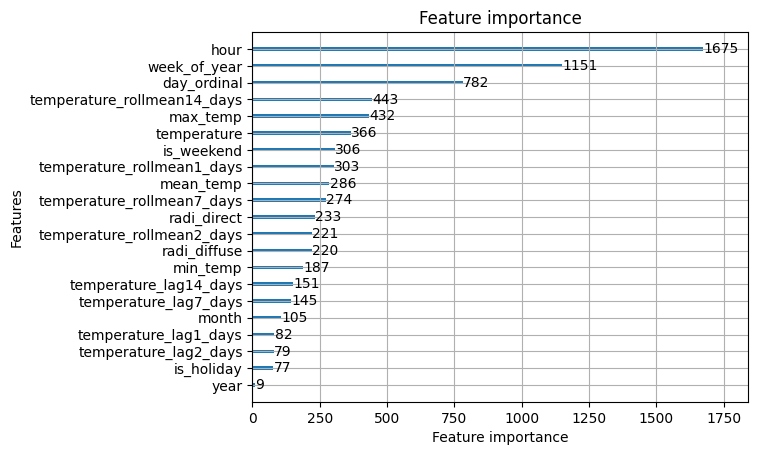

In [ ]:
# Give url for local mlflow server
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Load Forecasting: Hyperparameter Optimization")

# Consider functionalizing the model run: recall iteration_number = n
# Tags: (name of dataset1, name of dataset2)
# Experiments: (countries)
# Runs: (for models across countries)

# ... Seeking best set of models?

with mlflow.start_run(): 
    
    # Parameter set / ranges
    params = {
        'learning_rate': Real(0.001, 0.5, 'uniform'),
        'reg_alpha': Real(0, 1, 'uniform'),
        'num_leaves': Integer(20, 200, 'uniform'), # adjust
        'max_depth': Integer(3, 9, 'uniform'), # adjust if overfit
        #'subsample': Real(0.5, 1, 'uniform'), # research
        'colsample_bytree': Real(0.7, 1, 'uniform'),
        'reg_alpha': Real(0, 1, 'uniform'),
        'min_data_in_leaf': Integer(20, 100, 'uniform')
    } # reduce training time
    # path_smooth
    
    mlflow.log_params(params)

    # Optimization params
    iteration_number = 25 # ------
    opt = BayesSearchCV(
        model,
        params,
        cv=ts_cv,
        n_iter=iteration_number, # 50, 100
        scoring='neg_mean_absolute_percentage_error', # 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'
        n_jobs=-1,
        random_state=RANDOM_STATE,
        return_train_score=True,
        # keep_training_booster=True,
        optimizer_kwargs = {'base_estimator': 'RF'},
    )

    start = time.time()
    opt_model = opt.fit(X_train, y_train)
    end = round(time.time() - start, 2)

    mlflow.log_metrics({
        'optimization_iteration_number': iteration_number,
        'training_time': end,
        #'best_params': opt.best_params_,
        'best_mape': abs(opt_model.best_score_),
        # 'best_estimator'
    })

    mlflow.log_table(opt_model.best_params_, artifact_file='best_params.json')

    # Metrics to return
    #opt.cv_results_
    #opt.best_params_
    #opt.best_estimator_
    #opt.best_score_

    # Variable Importance Plot
    importance_plot = lgbm.plot_importance(opt.best_estimator_)
    mlflow.log_figure(importance_plot.figure, 'variable_importance.png') # any other args?
    
    # Performance on final test set
    # X_test, y_test = country_train_test(final_test_u)
    # y_pred = opt.best_estimator_.predict(X_test) # eval(final_test_u)

    # final_mape = mean_absolute_percentage_error(y_test, y_pred) 

    # mlflow.log_metrics({
    #         'optimization_iteration_number': iteration_number,
    #         'training_time': end,
    #         'best_training_mape': abs(opt.best_score_),
    #         'final_test_mape': final_mape,
    #     })
    
    # # Visualization on final test set
    # from matplotlib.pyplot as plt
    # import seaborn as sbn
    # plot_dt = pd.DataFrame({'time': X_test['utc_timestamp'],
    #                         'predicted': y_pred, 
    #                         'actual'y_test: })

    # sbn.lineplot(data = )

    # mlflow.log_figure(importance_plot.figure, 'variable_importance.png') # any other args?

    # Save model?

In [ ]:

X_test, y_test = country_train_test(final_test_u, drop_index=False) # preserve index for plotting
# alt, place best params into model
y_pred = opt_model.best_estimator_.predict(X_test) # eval(final_test_u)

# mape = mean_absolute_percentage_error(y_test, y_pred)  

# plot_dt = pd.DataFrame({'testing': X_test['utc_timestamp'],
#                         'predicted': y_pred, 
#                         'actual': y_test})

# import matplotlib.pyplot as plt
# import seaborn as sbn
# sbn.lineplot(data=plot_dt, x='testing', y=y_pred)
# sbn.lineplot(data=plot_dt, x='testing', y=y_test)
# plt.show()


AttributeError: 'BayesSearchCV' object has no attribute 'best_estimator_'

Optimized Model Final Test Set Performance and Visualizations

In [ ]:
### Functionalize model, then run with lags removed from the dataset

Results Graphs (MLflow)

Best Model on final validation set